In [1]:
%matplotlib inline
import emcee
import corner
import time
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as pl
import scipy.integrate as integrate
import scipy.linalg as linalg
import IPython
from matplotlib.ticker import MaxNLocator
from multiprocessing.pool import ThreadPool
from getdist import plots, MCSamples, loadMCSamples, types
from scipy.special import gamma
from scipy.integrate import quad

global argsortz #array de indices de zsni ordenados

import os
os.environ["OMP_NUM_THREADS"] = "1"

np.random.seed(321)

### Data

In [2]:
#32 H(z) data
#filename = 'data/Hz32Clocks.txt'
filename = 'mock_cosmic_chronometers.dat'
zhzi, hzi, shzi = np.genfromtxt(filename, comments='#', usecols=(0,1,2), unpack=True)

#Covariance data
filename = 'data/data_MM20.dat'
zmod, imf, slib, sps, spsooo = np.genfromtxt(filename, comments='#', usecols=(0,1,2,3,4), unpack=True)

#number of data
ndata = len(zhzi)

### Some default configurations

In [3]:
pl.rcParams['text.usetex'] = True
pl.rcParams.update(pl.rcParamsDefault)
priorArray = np.array([[50., 100.], [0.0, 3.0], [-3.0, 3.0], [0.1, 2]])
nstepHz = 5000

### Analysis functions

In [4]:
#Function to identify which model will be used
def free_par(theta, freef, flat):
    if freef == True:
        if flat == False:
            h0, wm, wl, f = theta
            return [h0, wm, wl, f]
        elif flat == True:
            h0, wm, f = theta
            return [h0, wm, 1-wm, f]
        else:
            print("Invalid flatness...")
            return None
    elif freef == False:
        if flat == False:
            h0, wm, wl = theta
            return [h0, wm, wl, 1]
        elif flat == True:
            h0, wm = theta
            return [h0, wm, 1-wm, 1]
        else:
            print("Invalid flatness...")
            return None
    else:
        print("Invalid correction parameter...")
        return None

#Calculate chi2 for the model
def chi2Hz(par):
    E2 = par[1]*(1+zhzi)**3+(1-par[1]-par[2])*(1+zhzi)**2+par[2]

    if np.any(E2<0):
        return np.inf

    Hzm = par[0]*np.sqrt(E2)
    dhz = hzi-Hzm
    inv_covCorr = inv_cov/par[3]**2

    return np.dot(np.dot(dhz.T, inv_covCorr), dhz)

#Check if parameters are in prior interval
def lnpriorHz(par):
    for i in range(len(par)):
        if not priorArray[i][0] < par[i] < priorArray[i][1]:
            return -np.inf
    return 0.0

#Calculate the likelihood
def lnlikeHz(par):
    chi2 = chi2Hz(par)
    return -0.5*chi2 - ndata*np.log(par[3])

def lnlikeHzA(par):
    chi2 = chi2Hz(par)
    return -0.5*chi2 - ndata*np.log(par[3])


def lnprobHz(theta, freef, flat):
    par = free_par(theta, freef, flat)
    
    lp = lnpriorHz(par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikeHz(par)

#Minimize chi2
def find_bestfit(lnlike, par_ml, parnames, freef, flat):
    t1 = time.time()
    ndim = len(par_ml)
    chi2 = lambda par_ml, freef, flat: -2*lnlike(par_ml, freef, flat)
    result = op.minimize(chi2, par_ml, args=(freef, flat))
    if not result['success']:
        result = op.minimize(chi2, par_ml, args=(freef, flat), method='Nelder-Mead', options={'maxiter': 10000})
    par_ml = result['x']
    print('Maximum likelihood result:')
    for i in range(ndim):
        print(parnames[i],' = ',par_ml[i])
    print('chi2min =',result['fun'])
    t2 = time.time()
    print('Total time: {0:5.3f} seg'.format(t2-t1))
    return result

#Run MC
def run_emcee(par_ml, nwalkers, lnprob, freef, flat, ainput, nsteps):
    ndim = len(par_ml)
    pos = [par_ml +1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    
    with ThreadPool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[freef, flat], a=ainput, pool=pool)
        sampler.run_mcmc(pos, nsteps, progress=True)
    
    accept = sampler.acceptance_fraction
    print('Acceptance fraction:',accept)
    print('Minimum acceptance:',np.amin(accept))
    print('Maximum acceptance:',np.amax(accept))
    
    return sampler

#Remove burn in
def tira_burnin(sampler, burnin, ndim):
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    return samples


def burninthin(sampler, tau):
    taumax = np.amax(tau)
    taumin = np.amin(tau)
    samples = sampler.get_chain(discard=int(2*taumax), thin=int(taumin/2), flat=True)
    print(samples.shape)
    return samples

#MC results
def MC_result(samples, par_ml, parnames):
    ndim = len(par_ml)
    par_mean = np.mean(samples,axis=0)
    par_median = np.percentile(samples, [50], axis=0)[0]
    par_valm = np.percentile(samples, [15.865525393149998], axis=0)[0]
    par_valp = np.percentile(samples, [84.13447460685], axis=0)[0]
    par_valm2 = np.percentile(samples, [2.275013194800002], axis=0)[0]
    par_valp2 = np.percentile(samples, [97.7249868052], axis=0)[0]
    par_sigm = par_mean - par_valm
    par_sigp = par_valp - par_mean
    par_sigm2 = par_mean - par_valm2
    par_sigp2 = par_valp2 - par_mean
    print('MCMC result:')
    for i in range(ndim):
        print("""{0} = {1:5.5f} +{2:5.5f} +{3:5.5f} -{4:5.5f} -{5:5.5f} (median: {6:5.5f}, ml: {7:5.5f})"""\
              .format(parnames[i],par_mean[i],par_sigp[i],par_sigp2[i],par_sigm[i],par_sigm2[i],par_median[i],par_ml[i]))

#Insert a derived paramater
def insertDerived(sample, parnames, parlabel, num, gsample, derived, derivedName, derivedLabel):
    n = np.zeros(num)
    
    if derivedName not in parnames:
        newSample = np.c_[sample, derived]
        parnames.append(derivedName)
        gsample.addDerived(derived, name=derivedName, label=derivedLabel)
        
        return newSample, gsample, parnames, n

    elif derivedName in parnames:
        print('Parâmetro dependente já adicionado.')

        return sample, gsample, parnames, n

#Distribution funcion for chi2
def chiDist(chi, n):
    return (n**(n/2)*((chi)**((n-2)/2))*np.exp(-(n/2)*chi))/(2**(n/2)*gamma(n/2))

#Calculate cdf for chiDist
def chiCDF(x, n):
    res = np.zeros_like(x)
    for i, val in enumerate(x):
        y, err = quad(chiDist, 0, val, args=(n))
        res[i]=y
    return res

#Plot chi2 cdf
def plotChiDist(chimin, par, name=0):
    n = ndata - par
    chi = np.linspace(0, 2.5, 500)
    chiv = np.full((500), chimin/n)
    hv = chiDist(chi, n)
    cdf = chiCDF(chi, n)
    y = np.linspace(0, 1.8, 500)
    
    pl.plot(chi, hv, label=r"$h _{\nu}$")
    pl.plot(chiv, y, '--', label=r"$\chi _{\nu} ^{2}$" + "$= {0}$".format(np.round(chimin/n, 3)))
    pl.plot(chi, cdf, '--', label="cdf")
    
    pl.xticks(np.arange(0.0, 2.51, 0.5))
    pl.yticks(np.arange(0.0, 1.76, 0.25))
    pl.axis((0, 2.5, 0, 1.75))
    pl.grid(linestyle='-.', linewidth='0.5')
    pl.minorticks_on()
    
    pl.ylabel(r'$h_{\nu}$')
    pl.xlabel(r'$\chi _{\nu} ^{2}$')
    pl.legend(loc='best')
   
    if not name == 0:
        pl.savefig(name+'.pdf')
    
    pl.show()

## Computing the covariance matrix

In [5]:
cov_mat = np.zeros((ndata, ndata), dtype='float64')

for i in range(ndata):
    cov_mat[i,i] = shzi[i]**2

inv_cov = linalg.inv(cov_mat)

In [ ]:
cov_mat_diag = np.zeros((ndata, ndata), dtype='float64')

for i in range(ndata):
    cov_mat_diag[i,i] = shzi[i]**2

imf_intp = np.interp(zhzi, zmod, imf)/100
spsooo_intp = np.interp(zhzi, zmod, spsooo)/100

cov_mat_imf = np.zeros((ndata, ndata), dtype='float64')
cov_mat_spsooo = np.zeros((ndata, ndata), dtype='float64')

for i in range(ndata):
    for j in range(ndata):
        cov_mat_imf[i,j] = hzi[i] * imf_intp[i] * hzi[j] * imf_intp[j]
        cov_mat_spsooo[i,j] = hzi[i] * spsooo_intp[i] * hzi[j] * spsooo_intp[j]

cov_mat = cov_mat_imf + cov_mat_spsooo + cov_mat_diag
inv_cov = linalg.inv(cov_mat)

# Uncorrected LCDM with curvature

In [19]:
par_HzC = [69.1929957609451,0.2480895086492853, 0.6862431649000225]
ndimC = len(par_HzC)
prefixC = 'LcdmHz32Cov'
parlabelsC = ["H_0","\\Omega_m", "\\Omega_\\Lambda"]
parlabtexC = ["$H_0$","$\\Omega_m$", "$\\Omega_\\Lambda$"]
parnamesC = ['H0','wm','wl']

resultHzC = find_bestfit(lnprobHz, par_HzC, parnamesC, freef=False, flat=False)
par_HzC = resultHzC['x']

Maximum likelihood result:
H0  =  68.4357396538443
wm  =  0.3746710821919484
wl  =  0.7837201559829245
chi2min = 14.475292392114685
Total time: 0.016 seg


In [20]:
samplerHzC = run_emcee(par_HzC, 100, lnprobHz, False, False, 2.0, nstepHz)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 131.62it/s]

Acceptance fraction: [0.6334 0.6346 0.6298 0.6378 0.6284 0.6346 0.63   0.6416 0.6408 0.6392
 0.6304 0.6304 0.6214 0.6374 0.6378 0.6458 0.6476 0.62   0.6288 0.626
 0.6294 0.6282 0.622  0.6334 0.6366 0.6408 0.6282 0.6324 0.6322 0.6384
 0.619  0.6382 0.63   0.637  0.6322 0.6272 0.6324 0.6282 0.6198 0.6368
 0.6332 0.6228 0.6472 0.6304 0.6322 0.6464 0.6248 0.6512 0.6444 0.6312
 0.6302 0.6278 0.6454 0.636  0.632  0.6424 0.641  0.6152 0.6278 0.6296
 0.6194 0.6288 0.636  0.63   0.629  0.6392 0.631  0.6284 0.6248 0.6342
 0.6322 0.634  0.636  0.6266 0.635  0.6234 0.6506 0.6396 0.6314 0.6412
 0.6328 0.6368 0.6332 0.623  0.6264 0.633  0.632  0.6418 0.6344 0.632
 0.627  0.6312 0.6298 0.6388 0.647  0.621  0.6322 0.6294 0.6348 0.6326]
Minimum acceptance: 0.6152
Maximum acceptance: 0.6512


In [21]:
tauHzC = samplerHzC.get_autocorr_time()
print(tauHzC)

tauHzmaxC = np.amax(tauHzC)
r = nstepHz/tauHzmaxC
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[42.78184352 39.77211236 41.30439792]
116.87200898475291
Convergiu! :)


In [22]:
samplesHzC = burninthin(samplerHzC, 100)

(9600, 3)


In [23]:
MC_result(samplesHzC, par_HzC, parnamesC)

MCMC result:
H0 = 66.48500 +6.33444 +12.13002 -6.37384 -12.48137 (median: 66.51877, ml: 68.43574)
wm = 0.37251 +0.20722 +0.42029 -0.21489 -0.34633 (median: 0.36384, ml: 0.37467)
wl = 0.68776 +0.41260 +0.76689 -0.41681 -0.81818 (median: 0.69710, ml: 0.78372)


In [24]:
gsamplesHzC = MCSamples(samples=samplesHzC, names=parnamesC, labels=parlabelsC, ranges={'wm':(0, None)})
gsamplesHzC.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


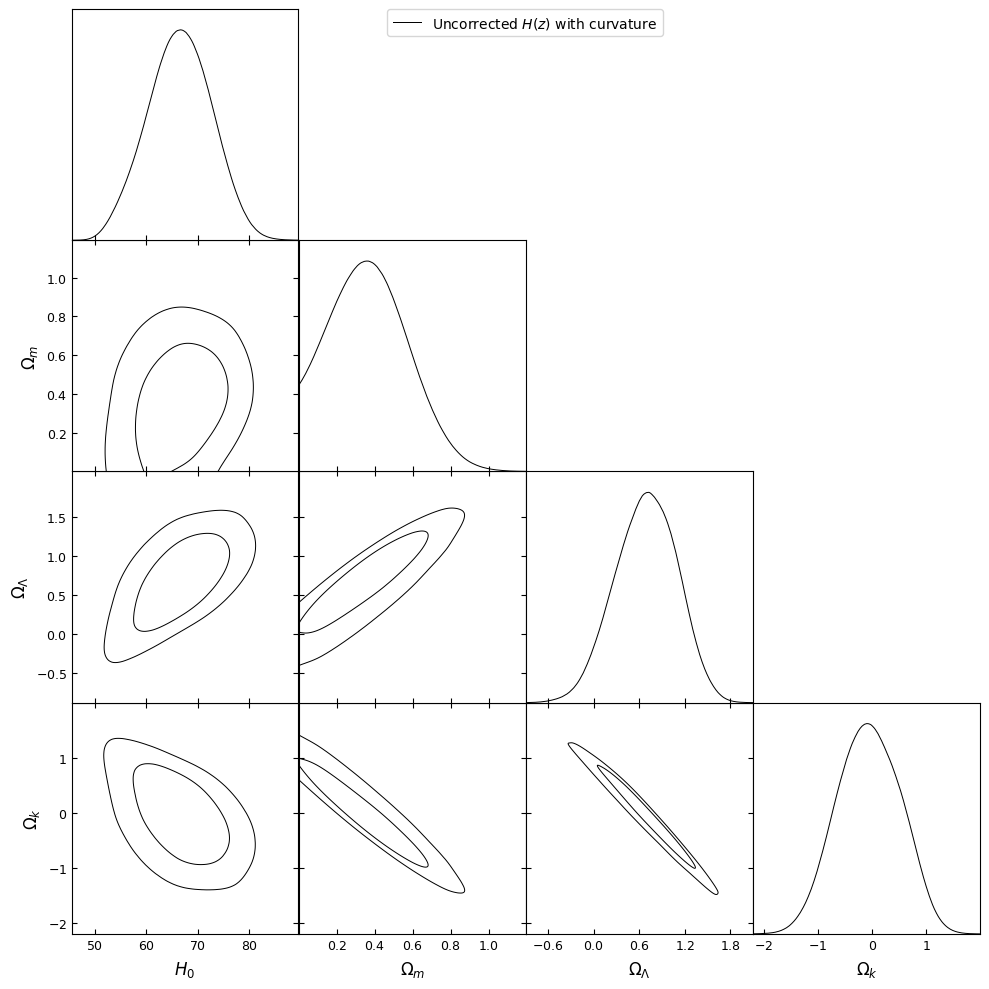

In [64]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzC], filled=False, legend_labels=['Uncorrected $H(z)$ with curvature'])
pl.show()
#g.export('fig/g'+prefixC+'All-triangle.pdf')

In [26]:
samplesHzC, gsamplesHzC, parnamesC, ndim = insertDerived(samplesHzC, parnamesC, parlabelsC, 4, gsamplesHzC, 1 - gsamplesHzC.getParams().wm - gsamplesHzC.getParams().wl, 'wk', '\\Omega_k')

In [27]:
MC_result(samplesHzC, ndim, parnamesC)

MCMC result:
H0 = 66.48500 +6.33444 +12.13002 -6.37384 -12.48137 (median: 66.51877, ml: 0.00000)
wm = 0.37251 +0.20722 +0.42029 -0.21489 -0.34633 (median: 0.36384, ml: 0.00000)
wl = 0.68776 +0.41260 +0.76689 -0.41681 -0.81818 (median: 0.69710, ml: 0.00000)
wk = -0.06027 +0.61121 +1.11601 -0.59873 -1.14958 (median: -0.06043, ml: 0.00000)


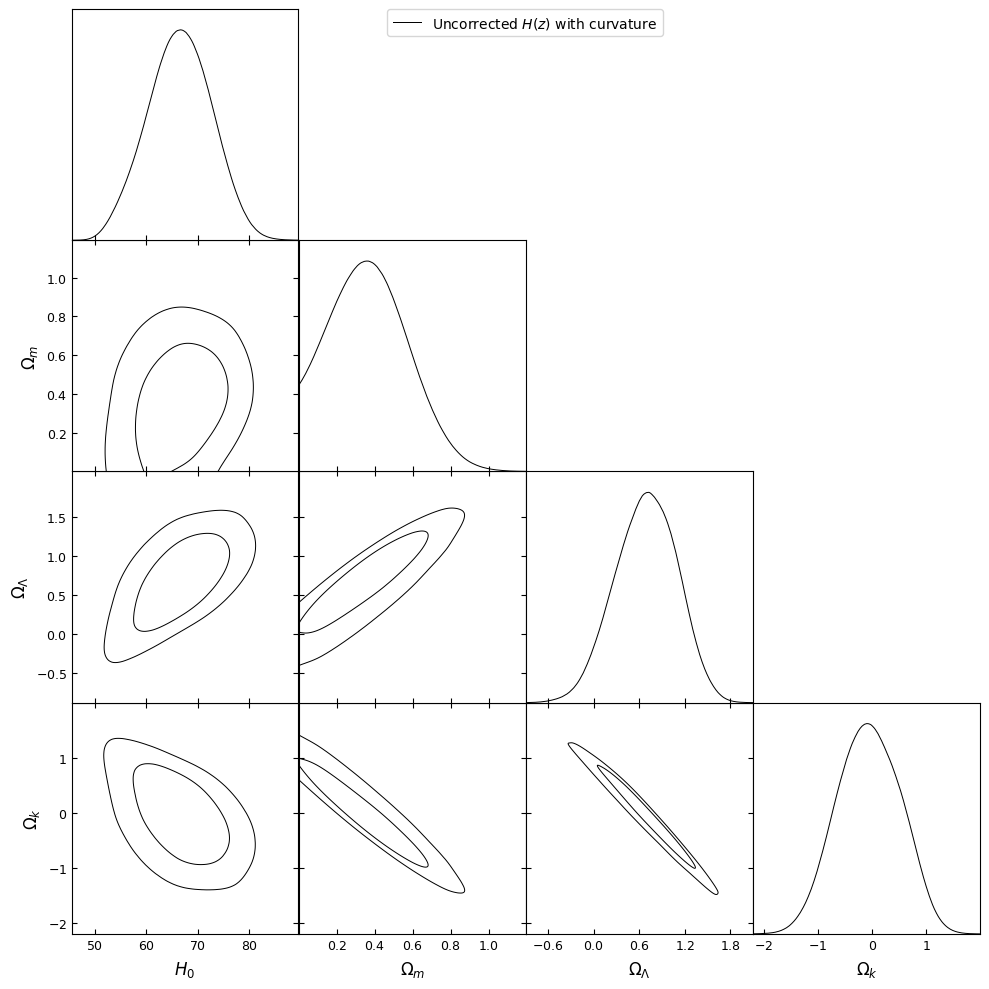

In [28]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzC], filled=False, legend_labels=['Uncorrected $H(z)$ with curvature'])
pl.show()
#g.export('fig/g'+prefixC+'All-triangle_Wk.pdf')

In [29]:
for i in range(len(ndim)):
    for j in range(1,4):
        print(gsamplesHzC.getInlineLatex(parnamesC[i],limit=j))
        
print(gsamplesHzC.getTable().tableTex())

H_0 = 66.5\pm 6.2
H_0 = 66^{+10}_{-10}
H_0 = 66^{+10}_{-10}
\Omega_m = 0.37^{+0.18}_{-0.24}
\Omega_m < 0.723
\Omega_m < 0.868
\Omega_\Lambda = 0.69^{+0.44}_{-0.38}
\Omega_\Lambda = 0.69^{+0.75}_{-0.81}
\Omega_\Lambda = 0.69^{+0.95}_{-1.1}
\Omega_k = -0.06\pm 0.58
\Omega_k = -0.1^{+1.1}_{-1.1}
\Omega_k = -0.1^{+1.4}_{-1.4}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $66^{+10}_{-10}            $\\

{\boldmath$\Omega_m       $} & $< 0.723                   $\\

{\boldmath$\Omega_\Lambda $} & $0.69^{+0.75}_{-0.81}      $\\

$\Omega_k                  $ & $-0.1^{+1.1}_{-1.1}        $\\
\hline
\end{tabular}


In [30]:
print(types.ResultTable(ncol=1,results=gsamplesHzC, paramList=parnamesC, limit=2).tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $66^{+10}_{-10}            $\\

{\boldmath$\Omega_m       $} & $< 0.723                   $\\

{\boldmath$\Omega_\Lambda $} & $0.69^{+0.75}_{-0.81}      $\\

$\Omega_k                  $ & $-0.1^{+1.1}_{-1.1}        $\\
\hline
\end{tabular}


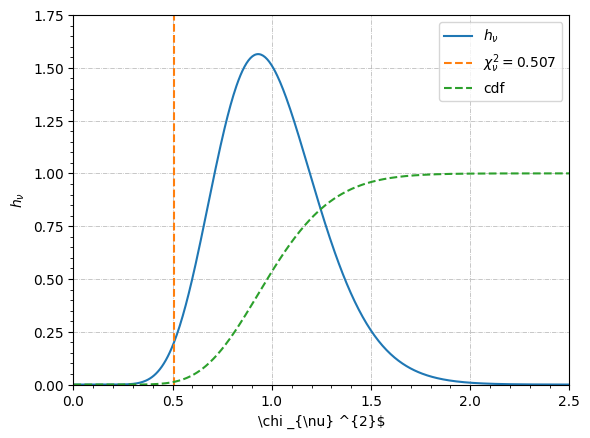

Probabilidade =  1.2711949898080448
Chiv =  0.5065335350094305


In [65]:
chi2mC = chi2Hz(free_par([66.60620, 0.37645, 0.69908], freef=False, flat=False))
chivCperc, errF = quad(chiDist, 0, chi2mC/(ndata-len(par_HzC)), args=(ndata-len(par_HzC)))
plotChiDist(chi2mC, len(par_HzC))
print('Probabilidade = ', chivCperc*100)
print('Chiv = ', chi2mC/(ndata-len(par_HzC)))

# Corrected LCDM with curvature

In [7]:
par_HzCF = [69.1929957609451,0.2480895086492853, 0.6862431649000225, .9]
ndimCF = len(par_HzCF)
prefixCF = 'LcdmHz32Cov'
parlabelsCF = ["H_0","\\Omega_m", "\\Omega_\\Lambda", "f"]
parlabtexCF = ["$H_0$","$\\Omega_m$", "$\\Omega_\\Lambda$", "$f$"]
parnamesCF = ['H0','wm','wl', 'f']

resultHzCF = find_bestfit(lnprobHz, par_HzCF, parnamesCF, freef=True, flat=False)
par_HzCF = resultHzCF['x']

Maximum likelihood result:
H0  =  68.43573467548853
wm  =  0.37467105254039906
wl  =  0.7837200228628217
f  =  0.6725718558132805
chi2min = 6.614634248192143
Total time: 0.019 seg


In [8]:
samplerHzCF = run_emcee(par_HzCF, 100, lnprobHz, True, False, 2.0, nstepHz)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:33<00:00, 147.10it/s]

Acceptance fraction: [0.5824 0.5854 0.5786 0.5802 0.5912 0.5718 0.5726 0.5782 0.5834 0.5874
 0.5748 0.583  0.579  0.578  0.5666 0.5862 0.5992 0.5836 0.5762 0.5896
 0.5946 0.5856 0.58   0.5776 0.5938 0.5874 0.5838 0.5904 0.5858 0.5846
 0.5868 0.5858 0.581  0.6104 0.5764 0.5872 0.5908 0.5972 0.5808 0.5862
 0.5694 0.5968 0.5894 0.584  0.593  0.5812 0.5804 0.5942 0.5924 0.5902
 0.579  0.5824 0.5792 0.5778 0.5978 0.5768 0.5706 0.57   0.578  0.5826
 0.5752 0.5772 0.5868 0.5826 0.5856 0.586  0.5744 0.5738 0.5806 0.5812
 0.5874 0.586  0.5798 0.5832 0.5876 0.582  0.5836 0.5774 0.5848 0.5774
 0.594  0.5814 0.5908 0.5872 0.5762 0.5864 0.5776 0.5774 0.5962 0.5862
 0.5762 0.5824 0.584  0.5896 0.5952 0.578  0.5962 0.581  0.5844 0.579 ]
Minimum acceptance: 0.5666
Maximum acceptance: 0.6104


In [9]:
tauHzCF = samplerHzCF.get_autocorr_time()
print(tauHzCF)

tauHzmaxCF = np.amax(tauHzCF)
r = nstepHz/tauHzmaxCF
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[46.554432   47.39655893 47.06174871 47.54761566]
105.15774409172826
Convergiu! :)


In [10]:
samplesHzCF = burninthin(samplerHzCF, 100)

(9600, 4)


In [11]:
MC_result(samplesHzCF, par_HzCF, parnamesCF)

MCMC result:
H0 = 67.11391 +4.72074 +9.44498 -4.75346 -9.82122 (median: 67.15582, ml: 68.43573)
wm = 0.35789 +0.15761 +0.32332 -0.16460 -0.30640 (median: 0.35932, ml: 0.37467)
wl = 0.70170 +0.32256 +0.59682 -0.32424 -0.68437 (median: 0.72055, ml: 0.78372)
f = 0.73762 +0.09542 +0.23947 -0.09940 -0.17180 (median: 0.72669, ml: 0.67257)


In [12]:
gsamplesHzCF = MCSamples(samples=samplesHzCF, names=parnamesCF, labels=parlabelsCF, ranges={'wm':(0, None)})
gsamplesHzCF.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


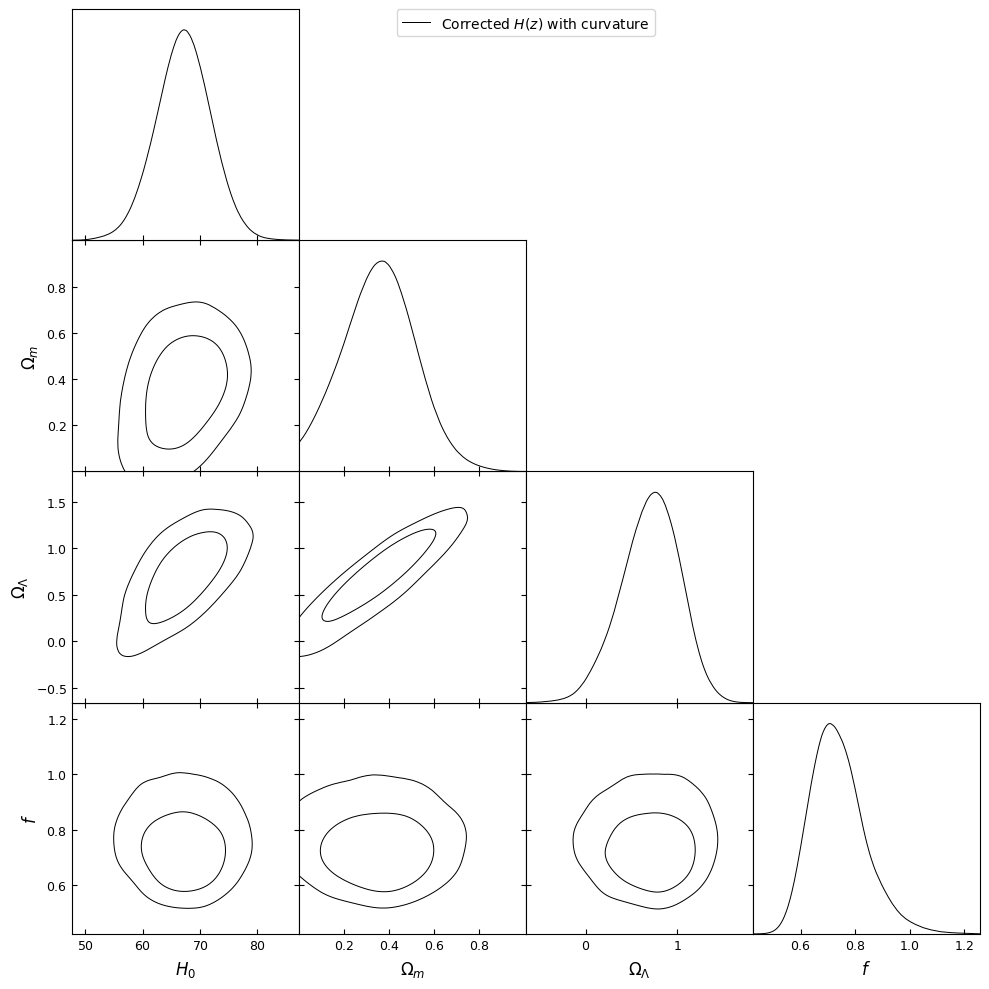

In [13]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzCF], filled=False, legend_labels=['Corrected $H(z)$ with curvature'])
pl.show()
#g.export('fig/g'+prefixCF+'All-triangle.pdf')

In [14]:
samplesHzCF1, gsamplesHzCF1, parnamesCF1, ndimCF1 = insertDerived(samplesHzCF, parnamesCF, parlabelsCF, 5, gsamplesHzCF, 1 - gsamplesHzCF.getParams().wm - gsamplesHzCF.getParams().wl, 'wk', '\\Omega_k')

In [15]:
MC_result(samplesHzCF1, ndimCF1, parnamesCF1)

MCMC result:
H0 = 67.11391 +4.72074 +9.44498 -4.75346 -9.82122 (median: 67.15582, ml: 0.00000)
wm = 0.35789 +0.15761 +0.32332 -0.16460 -0.30640 (median: 0.35932, ml: 0.00000)
wl = 0.70170 +0.32256 +0.59682 -0.32424 -0.68437 (median: 0.72055, ml: 0.00000)
f = 0.73762 +0.09542 +0.23947 -0.09940 -0.17180 (median: 0.72669, ml: 0.00000)
wk = -0.05958 +0.47586 +0.95068 -0.46784 -0.88474 (median: -0.07815, ml: 0.00000)


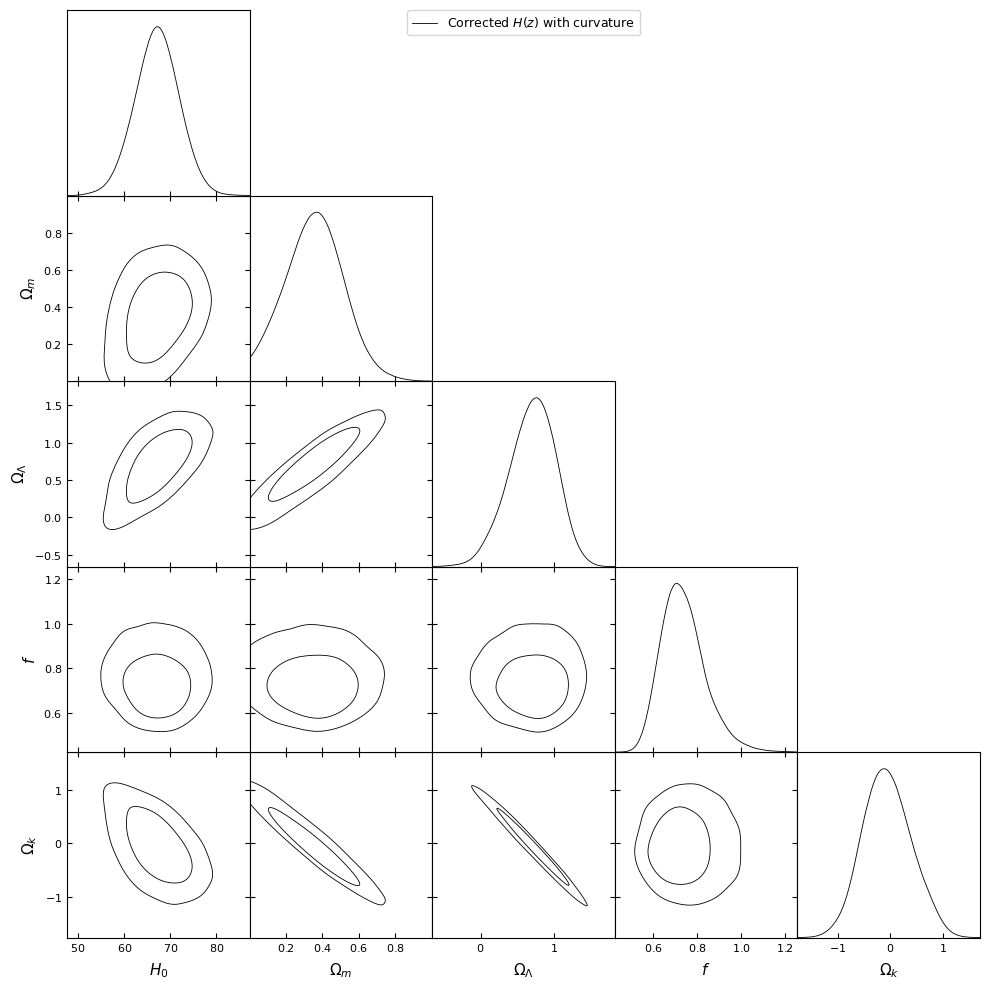

In [16]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzCF1], filled=False, legend_labels=['Corrected $H(z)$ with curvature'])
pl.show()
#g.export('fig/g'+prefixCF+'All-triangle_Wk.pdf')

In [17]:
for i in range(len(ndim)):
    for j in range(1,4):
        print(gsamplesHzCF.getInlineLatex(parnamesCF[i],limit=j))
        
print(gsamplesHzCF.getTable().tableTex())

NameError: name 'ndim' is not defined

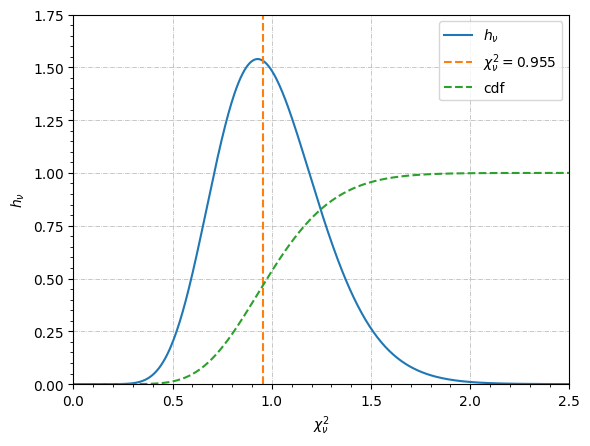

Probabilidade =  46.81143717555001
Chiv =  0.9553601869454954


In [18]:
chi2CF=chi2Hz(free_par([67.16828,0.36434,0.71192,0.73771], freef=True, flat=False))
plotChiDist(chi2CF, len(par_HzCF), name='chi2OLCDM')
chivCFperc, errF = quad(chiDist, 0, chi2CF/(ndata-len(par_HzCF)), args=(ndata-len(par_HzCF)))
print('Probabilidade = ', chivCFperc*100)
print('Chiv = ', chi2CF/(ndata-len(par_HzCF)))

# Comparison between corrected and uncorrected H(z) with curvature

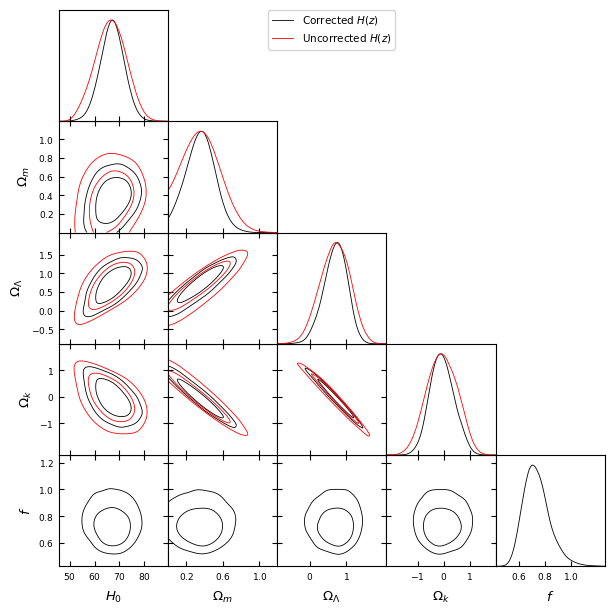

In [65]:
g = plots.getSubplotPlotter(subplot_size=1.25)
g.triangle_plot([gsamplesHzCF1, gsamplesHzC], [parnamesCF[0],parnamesCF[1],parnamesCF[2],parnamesCF[4],parnamesCF[3]],filled=False, legend_labels=['Corrected $H(z)$','Uncorrected $H(z)$'])
g.export('fig/gcompUncCorrAll-triangle.pdf')
pl.show()

# Uncorrected Flat LCDM

In [6]:
par_HzF = [69.1929957609451, 0.2480895086492853]
ndimF = len(par_HzF)
prefixF = 'FlatLcdmHz32Cov'
parlabelsF = ["H_0","\\Omega_m"]
parlabtexF = ["$H_0$","$\\Omega_m$"]
parnamesF = ['H0','wm']

resultHzF = find_bestfit(lnprobHz, par_HzF, parnamesF, freef=False, flat=True)
par_mlHzF = resultHzF['x']

Maximum likelihood result:
H0  =  67.87414550806099
wm  =  0.3008134153125312
chi2min = 100.83969459261824
Total time: 0.007 seg


In [7]:
samplerHzF = run_emcee(par_HzF, 100, lnprobHz, False, True, 2.0, nstepHz)

100%|██████████████████████████████████████| 5000/5000 [00:45<00:00, 109.88it/s]

Acceptance fraction: [0.7104 0.7302 0.7042 0.7136 0.7112 0.7136 0.7142 0.717  0.715  0.722
 0.7134 0.721  0.7096 0.7136 0.72   0.7202 0.7236 0.7072 0.7162 0.71
 0.714  0.7186 0.7094 0.7092 0.7268 0.7258 0.7108 0.7128 0.714  0.7202
 0.7088 0.7222 0.7256 0.7234 0.7204 0.7188 0.7158 0.7126 0.7078 0.715
 0.7028 0.7244 0.713  0.716  0.7176 0.7368 0.7068 0.7186 0.7324 0.7146
 0.7112 0.7186 0.7234 0.7212 0.7104 0.7162 0.7134 0.7096 0.7014 0.7184
 0.7114 0.7066 0.7224 0.7122 0.7166 0.714  0.706  0.7086 0.7116 0.7136
 0.7188 0.7074 0.7244 0.7024 0.728  0.7176 0.7272 0.719  0.7118 0.7238
 0.711  0.724  0.7196 0.7158 0.7146 0.7162 0.7026 0.7142 0.7224 0.7188
 0.7196 0.7038 0.7128 0.7202 0.7142 0.6976 0.7228 0.711  0.7262 0.7136]
Minimum acceptance: 0.6976
Maximum acceptance: 0.7368


In [9]:
tauHzF = samplerHzF.get_autocorr_time()
print(tauHzF)

tauHzmaxF = np.amax(tauHzF)
r = nstepHz/tauHzmaxF
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[30.88991426 31.78910063]
157.28661399327092
Convergiu! :)


In [10]:
samplesHzF = burninthin(samplerHzF, tauHzF)

(32900, 2)


In [11]:
MC_result(samplesHzF, par_HzF, parnamesF)

MCMC result:
H0 = 67.83735 +0.94862 +1.86512 -0.94717 -1.90673 (median: 67.84433, ml: 69.19300)
wm = 0.30188 +0.01817 +0.03768 -0.01821 -0.03524 (median: 0.30144, ml: 0.24809)


In [12]:
gsamplesHzF = MCSamples(samples=samplesHzF, names=parnamesF, labels=parlabelsF, ranges={'wm':(0, None)})
gsamplesHzF.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


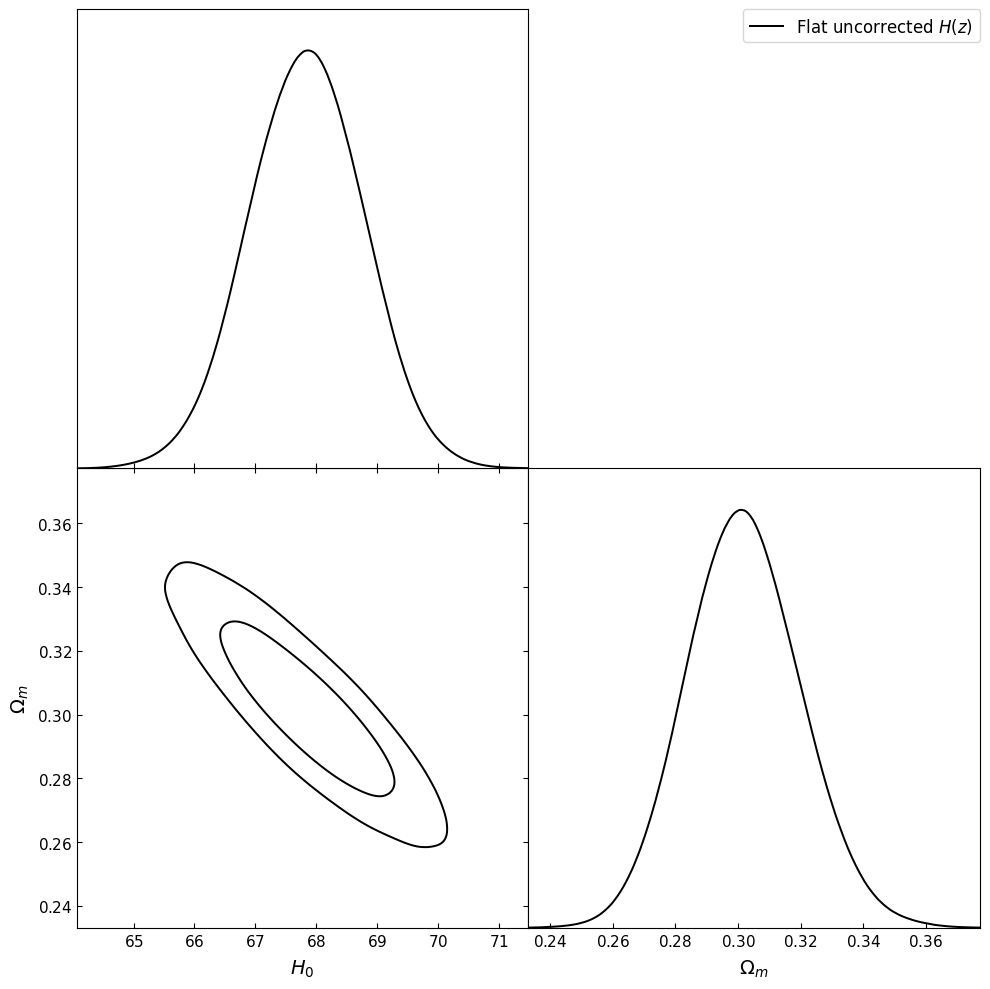

In [15]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzF], filled=False, legend_labels=['Flat uncorrected $H(z)$'])
pl.show()
#g.export('fig/g'+prefixF+'All-triangle.pdf')

In [58]:
samplesHzF, gsamplesHzF, parnamesF, ndim = insertDerived(samplesHzF, parnamesF, parlabelsF, 3, gsamplesHzF, 1 - gsamplesHzF.getParams().wm, 'wl', '\\Omega _{\\Lambda}')

In [59]:
MC_result(samplesHzF, ndim, parnamesF)

MCMC result:
H0 = 66.72630 +5.46125 +10.90029 -5.51658 -10.97125 (median: 66.75385, ml: 0.00000)
wm = 0.34176 +0.07072 +0.17123 -0.07118 -0.12184 (median: 0.33326, ml: 0.00000)
wl = 0.65824 +0.07118 +0.12184 -0.07072 -0.17123 (median: 0.66674, ml: 0.00000)


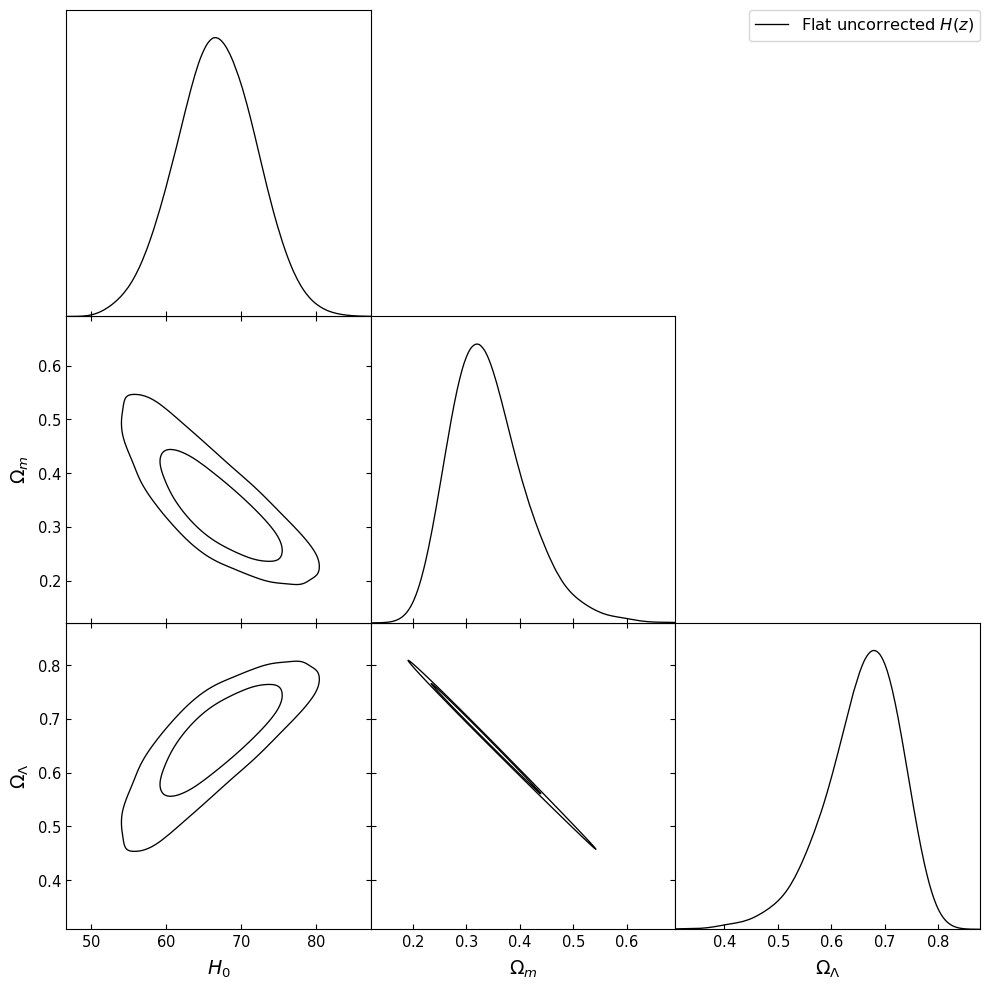

In [73]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzF], filled=False, legend_labels=['Flat uncorrected $H(z)$'])
pl.show()
#g.export('fig/g'+prefixF+'All-triangle_Wl.pdf')

In [60]:
for i in range(ndimF+1):
    for j in range(1,4):
        print(gsamplesHzF.getInlineLatex(parnamesF[i],limit=j))
        
print(gsamplesHzF.getTable().tableTex())

H_0 = 66.7\pm 5.5
H_0 = 67^{+10}_{-10}
H_0 = 67^{+10}_{-10}
\Omega_m = 0.342^{+0.054}_{-0.084}
\Omega_m = 0.34^{+0.15}_{-0.13}
\Omega_m = 0.34^{+0.24}_{-0.15}
\Omega _{\Lambda} = 0.658^{+0.084}_{-0.054}
\Omega _{\Lambda} = 0.66^{+0.13}_{-0.15}
\Omega _{\Lambda} = 0.66^{+0.15}_{-0.24}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+10}_{-10}            $\\

{\boldmath$\Omega_m       $} & $0.34^{+0.15}_{-0.13}      $\\

$\Omega _{\Lambda}         $ & $0.66^{+0.13}_{-0.15}      $\\
\hline
\end{tabular}


In [61]:
print(types.ResultTable(ncol=1,results=gsamplesHzF, paramList=parnamesF, limit=2).tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+10}_{-10}            $\\

{\boldmath$\Omega_m       $} & $0.34^{+0.15}_{-0.13}      $\\

$\Omega _{\Lambda}         $ & $0.66^{+0.13}_{-0.15}      $\\
\hline
\end{tabular}


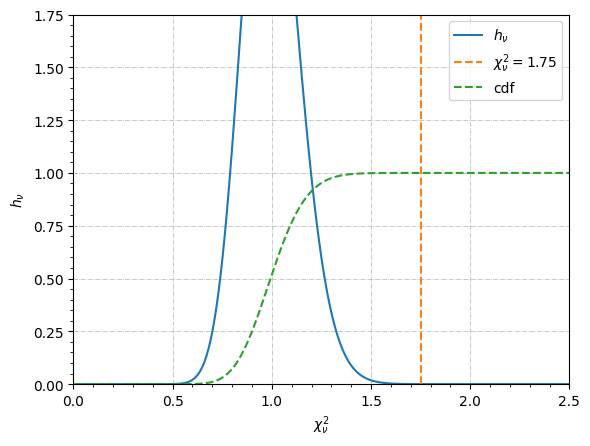

Probabilidade =  99.99936888802955
Chiv =  1.7503926888332446


In [16]:
chi2F=chi2Hz(free_par([56.84412,0.40977], freef=False, flat=True))
plotChiDist(chi2F, len(par_HzF))
chivFperc, errF = quad(chiDist, 0, chi2F/(ndata-len(par_HzF)), args=(ndata-len(par_HzF)))
print('Probabilidade = ', chivFperc*100)
print('Chiv = ', chi2F/(ndata-len(par_HzF)))

# Corrected Flat LCDM

In [17]:
par_HzFf = [69.1929957609451,0.2480895086492853, .9]
ndimFf = len(par_HzFf)
prefixFf = 'LcdmHz32CovCorr'
parlabelsFf = ['H_0','\\Omega_m', 'f']
parlabtexFf = ['$H_0$','$\\Omega_m$', '$f$']
parnamesFf = ['H0','wm', 'f']

resultHzFf = find_bestfit(lnprobHz, par_HzFf, parnamesFf, freef=True, flat=True)
par_mlHzFf = resultHzFf['x']

Maximum likelihood result:
H0  =  56.845090344067984
wm  =  0.4097352735034734
f  =  1.3097206689657528
chi2min = 153.96363365742874
Total time: 0.040 seg


/home/nirk20/jupyter_venv/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/home/nirk20/jupyter_venv/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [25]:
samplerHzFf = run_emcee(par_HzFf, 100, lnprobHz, True, True, 2.0, 20000)

100%|████████████████████████████████████| 20000/20000 [02:49<00:00, 117.99it/s]

Acceptance fraction: [0.6433  0.64955 0.64315 0.64025 0.6429  0.64515 0.6436  0.6415  0.64155
 0.64385 0.63995 0.64415 0.645   0.6394  0.64105 0.643   0.6485  0.6409
 0.6408  0.6471  0.65265 0.64785 0.63815 0.6419  0.6408  0.6427  0.64
 0.64715 0.6426  0.64275 0.64715 0.6449  0.6446  0.6423  0.6409  0.64655
 0.64935 0.6433  0.64295 0.6441  0.64025 0.64055 0.6484  0.64435 0.64155
 0.65055 0.64545 0.6388  0.63945 0.64575 0.6478  0.6425  0.6417  0.64045
 0.64435 0.6399  0.64935 0.63365 0.64505 0.64755 0.6418  0.639   0.64025
 0.63475 0.65075 0.64515 0.6405  0.64215 0.6439  0.64845 0.6376  0.64105
 0.6404  0.6407  0.64545 0.64445 0.646   0.64085 0.6484  0.6466  0.64135
 0.6411  0.6467  0.64465 0.6441  0.6464  0.6372  0.6474  0.6412  0.6509
 0.6427  0.63945 0.6444  0.64575 0.6391  0.64745 0.645   0.64015 0.65035
 0.6417 ]
Minimum acceptance: 0.63365
Maximum acceptance: 0.65265


In [26]:
tauHzFf = samplerHzFf.get_autocorr_time()
print(tauHzFf)

tauHzmaxFf = np.amax(tauHzFf)
r = nstepHz/tauHzmaxFf
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[112.41716276 109.48661586  35.89875961]
44.47719438293845
Não convergiu... :'(:


In [27]:
samplesHzFf = burninthin(samplerHzFf, tauHzFf)

(116300, 3)


In [28]:
MC_result(samplesHzFf, par_mlHzFf, parnamesFf)

MCMC result:
H0 = 56.84419 +0.21635 +0.43397 -0.21523 -0.43603 (median: 56.84336, ml: 56.84509)
wm = 0.40980 +0.00456 +0.00928 -0.00457 -0.00913 (median: 0.40978, ml: 0.40974)
f = 1.34108 +0.09654 +0.21159 -0.09669 -0.17756 (median: 1.33548, ml: 1.30972)


In [29]:
gsamplesHzFf = MCSamples(samples=samplesHzFf, names=parnamesFf, labels=parlabelsFf, ranges={'wm':(0, None)})
gsamplesHzFf.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


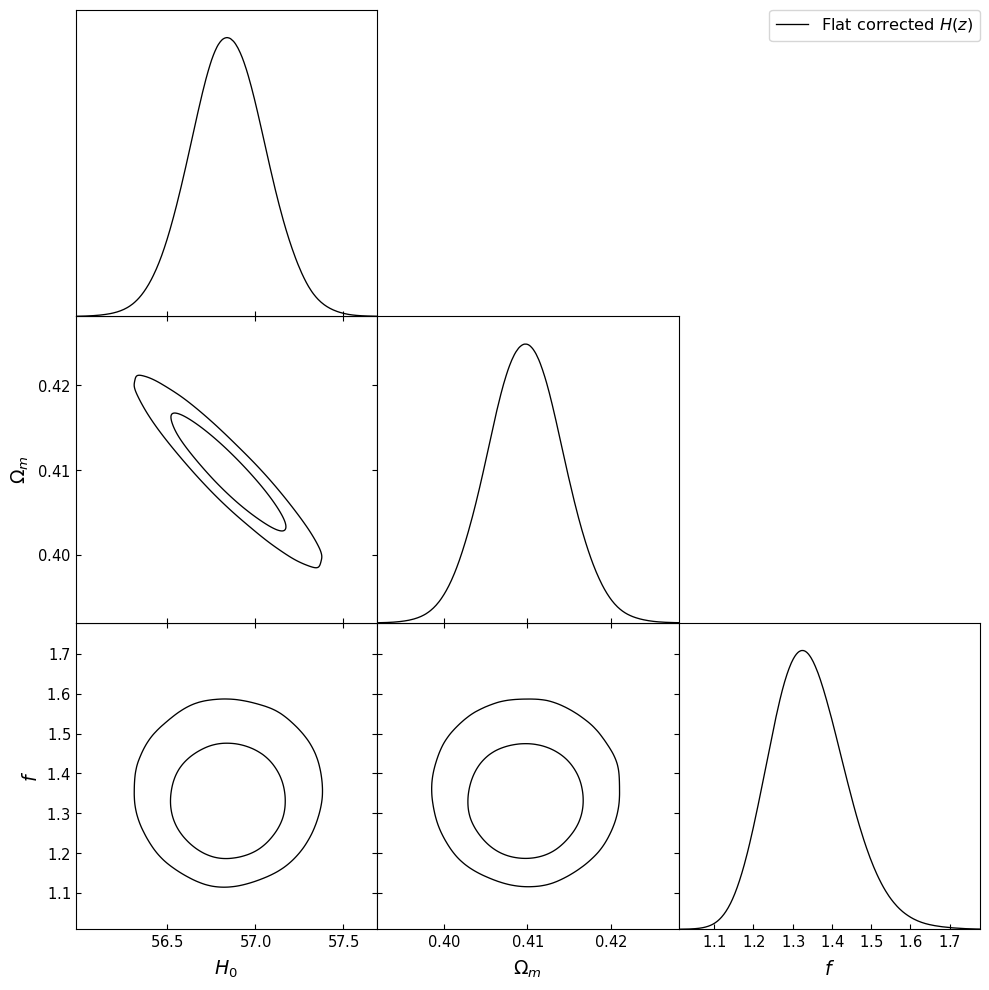

In [30]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzFf], filled=False, legend_labels=['Flat corrected $H(z)$'])
pl.show()
#g.export('fig/g'+prefixFf+'All-triangle.pdf')

In [17]:
samplesHzFf, gsamplesHzFf, parnamesFf, ndim = insertDerived(samplesHzFf, parnamesFf, parlabelsFf, 4, gsamplesHzFf, 1 - gsamplesHzFf.getParams().wm, 'wl', '\\Omega _{\\Lambda}')

In [18]:
MC_result(samplesHzFf, ndim, parnamesFf)

MCMC result:
H0 = 67.12013 +3.91956 +8.00602 -3.89938 -8.20400 (median: 67.13629, ml: 0.00000)
wm = 0.33270 +0.04975 +0.11914 -0.05016 -0.09021 (median: 0.32808, ml: 0.00000)
f = 0.72693 +0.09608 +0.23296 -0.09564 -0.16489 (median: 0.71542, ml: 0.00000)
wl = 0.66730 +0.05016 +0.09021 -0.04975 -0.11914 (median: 0.67192, ml: 0.00000)


In [19]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzFf], filled=False, legend_labels=['Flat corrected $H(z)$'])
pl.show
#g.export('fig/g'+prefixFf+'All-triangle_Wl.pdf')

<function matplotlib.pyplot.show(close=None, block=None)>

In [20]:
for i in range(ndimFf+1):
    for j in range(1,4):
        print(gsamplesHzFf.getInlineLatex(parnamesFf[i],limit=j))
        
print(gsamplesHzFf.getTable().tableTex())

H_0 = 67.1\pm 4.0
H_0 = 67^{+8}_{-8}
H_0 = 67^{+10}_{-10}
\Omega_m = 0.333^{+0.040}_{-0.057}
\Omega_m = 0.333^{+0.11}_{-0.096}
\Omega_m = 0.33^{+0.17}_{-0.11}
f = 0.727^{+0.072}_{-0.11}
f = 0.73^{+0.20}_{-0.18}
f = 0.73^{+0.32}_{-0.20}
\Omega _{\Lambda} = 0.667^{+0.057}_{-0.040}
\Omega _{\Lambda} = 0.667^{+0.096}_{-0.11}
\Omega _{\Lambda} = 0.67^{+0.11}_{-0.17}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+8}_{-8}              $\\

{\boldmath$\Omega_m       $} & $0.333^{+0.11}_{-0.096}    $\\

{\boldmath$f              $} & $0.73^{+0.20}_{-0.18}      $\\

$\Omega _{\Lambda}         $ & $0.667^{+0.096}_{-0.11}    $\\
\hline
\end{tabular}


In [21]:
print(types.ResultTable(ncol=1,results=gsamplesHzFf, paramList=parnamesFf, limit=2).tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+8}_{-8}              $\\

{\boldmath$\Omega_m       $} & $0.333^{+0.11}_{-0.096}    $\\

{\boldmath$f              $} & $0.73^{+0.20}_{-0.18}      $\\

$\Omega _{\Lambda}         $ & $0.667^{+0.096}_{-0.11}    $\\
\hline
\end{tabular}


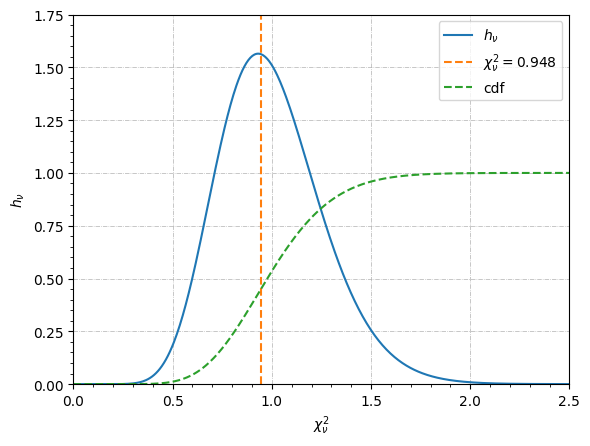

Probabilidade =  45.45382313023643
Chiv =  0.9478187654040636


In [23]:
chi2Ff=chi2Hz(free_par([67.10380,0.33287,0.72775], freef=True, flat=True))
plotChiDist(chi2Ff, len(par_HzFf), name='chi2FLCDM')
chivFfperc, errF = quad(chiDist, 0, chi2Ff/(ndata-len(par_HzFf)), args=(ndata-len(par_HzFf)))
print('Probabilidade = ', chivFfperc*100)
print('Chiv = ', chi2Ff/(ndata-len(par_HzFf)))

# Comparison between corrected and uncorrected Flat LCDM

In [59]:
g = plots.getSubplotPlotter(subplot_size=1.75)
g.triangle_plot([gsamplesHzFf, gsamplesHzF], [parnamesFf[0],parnamesFf[1],parnamesFf[2]], filled=False, legend_labels=['Corrected $H(z)$','Uncorrected $H(z)$'])
g.export('fig/gFlatcompUncCorrAll-triangle.pdf')

# Displacement in data no f

In [60]:
#Function to identify which model will be used
def free_parE(theta, freef, flat):
    if freef == True:
        if flat == False:
            h0, wm, wl, f , e= theta
            return [h0, wm, wl, f, e]
        elif flat == True:
            h0, wm, f, e= theta
            return [h0, wm, 1-wm, f, e]
        else:
            print("Invalid flatness...")
            return None
    elif freef == False:
        if flat == False:
            h0, wm, wl, e = theta
            return [h0, wm, wl, 1, e]
        elif flat == True:
            h0, wm, e = theta
            return [h0, wm, 1-wm, 1, e]
        else:
            print("Invalid flatness...")
            return None
    else:
        print("Invalid correction parameter...")
        return None

#Calculate chi2 for the model
def chi2HzE(par):
    E2 = par[1]*(1+zhzi)**3+(1-par[1]-par[2])*(1+zhzi)**2+par[2]

    if np.any(E2<0):
        return np.inf

    Hzm = par[4] + (par[0]-par[4])*np.sqrt(E2)
    dhz = hzi-Hzm
    inv_covCorr = inv_cov/par[3]**2

    return np.dot(np.dot(dhz.T, inv_covCorr), dhz)

#Check if parameters are in prior interval
def lnpriorHzE(par):
    for i in range(len(par)):
        if not priorArrayE[i][0] < par[i] < priorArrayE[i][1]:
            return -np.inf
    return 0.0

#Calculate the likelihood
def lnlikeHzE(par):
    chi2 = chi2HzE(par)
    return -0.5*chi2 - ndata*np.log(par[3])

#?
def lnprobHzE(theta, freef, flat):
    par = free_parE(theta, freef, flat)
    
    lp = lnpriorHzE(par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikeHzE(par)

#Minimize chi2
def find_bestfitE(lnlike, par_ml, parnames, freef, flat):
    t1 = time.time()
    ndim = len(par_ml)
    chi2 = lambda par_ml, freef, flat: -2*lnlike(par_ml, freef, flat)
    result = op.minimize(chi2, par_ml, args=(freef, flat))
    if not result['success']:
        result = op.minimize(chi2, par_ml, args=(freef, flat), method='Nelder-Mead', options={'maxiter': 10000})
    par_ml = result['x']
    print('Maximum likelihood result:')
    for i in range(ndim):
        print(parnames[i],' = ',par_ml[i])
    print('chi2min =',result['fun'])
    t2 = time.time()
    print('Total time: {0:5.3f} seg'.format(t2-t1))
    return result

priorArrayE = np.array([[50., 100.], [0.0, 3.0], [-3.0, 3.0], [0.1, 2], [-50,50]])

## Flat LCDM without factor f

In [61]:
par_HzE = [69.1929957609451,0.2480895086492853, 5.]
ndimE = len(par_HzE)
prefixE = 'LcdmHz32CovCorr'
parlabelsE = ['H_0','\Omega_m', '\epsilon']
parlabtexE = ['$H_0$','$\Omega_m$', '$\epsilon$']
parnamesE = ['H0','wm', 'e']

resultHzE = find_bestfit(lnprobHzE, par_HzE, parnamesE, freef=False, flat=True)
par_mlHzE = resultHzE['x']

Maximum likelihood result:
H0  =  67.9220083868301
wm  =  0.2585418562386453
e  =  -11.53060862031493
chi2min = 14.509563170806942
Total time: 0.033 seg


<>:4: SyntaxWarning: invalid escape sequence '\O'
<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\O'
<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\e'
C:\Users\nirk2\AppData\Local\Temp\ipykernel_15400\1451789100.py:4: SyntaxWarning: invalid escape sequence '\O'
  parlabelsE = ['H_0','\Omega_m', '\epsilon']
C:\Users\nirk2\AppData\Local\Temp\ipykernel_15400\1451789100.py:4: SyntaxWarning: invalid escape sequence '\e'
  parlabelsE = ['H_0','\Omega_m', '\epsilon']
C:\Users\nirk2\AppData\Local\Temp\ipykernel_15400\1451789100.py:5: SyntaxWarning: invalid escape sequence '\O'
  parlabtexE = ['$H_0$','$\Omega_m$', '$\epsilon$']
C:\Users\nirk2\AppData\Local\Temp\ipykernel_15400\1451789100.py:5: SyntaxWarning: invalid escape sequence '\e'
  parlabtexE

In [62]:
samplerHzE = run_emcee(par_HzE, 100, lnprobHzE, False, True, 2.0, nstepHz)

 13%|█████████▊                                                                    | 631/5000 [00:04<00:30, 141.76it/s]


KeyboardInterrupt: 

In [ ]:
tauHzE = samplerHzE.get_autocorr_time()
print(tauHzE)

tauHzmaxE = np.amax(tauHzE)
r = nstepHz/tauHzmaxE
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

In [ ]:
samplesHzE = burninthin(samplerHzE, tauHzE)

In [ ]:
MC_result(samplesHzE, par_mlHzE, parnamesE)

In [ ]:
gsamplesHzE = MCSamples(samples=samplesHzE, names=parnamesE, labels=parlabelsE, ranges={'wm':(0, None)})
gsamplesHzE.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

In [ ]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzE], filled=False, legend_labels=['Flat $\Lambda$CDM with $\epsilon$'])
#g.export('fig/g'+prefix0+'All-triangle.pdf')

In [ ]:
samplesHzE, gsamplesHzE, parnamesE, ndim = insertDerived(samplesHzE, parnamesE, parlabelsE, 4, gsamplesHzE, 1 - gsamplesHzE.getParams().wm, 'wl', '\Omega_l')

In [ ]:
MC_result(samplesHzE, ndim, parnamesE)

In [ ]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzE], filled=False, legend_labels=['Flat $\Lambda$CDM with $\epsilon$'])
#g.export('fig/g'+prefixE+'All-triangle_Wk.pdf')

In [6]:
chi2E=chi2HzE(free_parE([70.60362,0.32969,3.18051], freef=False, flat=True))
plotChiDist(chi2E, len(par_HzE))
chivEperc, errF = quad(chiDist, 0, chi2E/(ndata-len(par_HzE)), args=(ndata-len(par_HzE)))
print('Probabilidade = ', chivEperc*100)
print('Chiv = ', chi2E/(ndata-len(par_HzE)))

NameError: name 'chi2HzE' is not defined

## Flat LCDM with factor f

In [ ]:
par_HzEf = [69.1929957609451,0.2480895086492853,.9, 5.]
ndimEf = len(par_HzEf)
prefixEf = 'LcdmHz32CovCorr'
parlabelsEf = ['H_0','\Omega_m', 'f', '\epsilon']
parlabtexEf = ['$H_0$','$\Omega_m$', 'f', '$\epsilon$']
parnamesEf = ['H0','wm', 'f','e']

resultHzEf = find_bestfit(lnprobHzE, par_HzEf, parnamesEf, freef=True, flat=True)
par_mlHzEf = resultHzEf['x']

In [ ]:
samplerHzEf = run_emcee(par_HzEf, 100, lnprobHzE, True, True, 2.0, nstepHz)

In [ ]:
tauHzEf = samplerHzEf.get_autocorr_time()
print(tauHzEf)

tauHzmaxEf = np.amax(tauHzEf)
r = nstepHz/tauHzmaxEf
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

In [ ]:
samplesHzEf = burninthin(samplerHzEf, tauHzEf)

In [ ]:
MC_result(samplesHzEf, par_mlHzEf, parnamesEf)

In [ ]:
gsamplesHzEf = MCSamples(samples=samplesHzEf, names=parnamesEf, labels=parlabelsEf, ranges={'wm':(0, None)})
gsamplesHzEf.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

In [ ]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzEf], filled=False, legend_labels=['Flat $\Lambda$CDM with $\epsilon$ and f'])
#g.export('fig/g'+prefix0+'All-triangle.pdf')

In [ ]:
chi2Ef = chi2HzE(free_parE([71.28834, 0.32342, 0.72746, 3.75071], freef=True, flat=True))
plotChiDist(chi2Ef, len(par_HzEf))
chivEfperc, errF = quad(chiDist, 0, chi2Ef/(ndata-len(par_HzEf)), args=(ndata-len(par_HzEf)))
print('Probabilidade = ', chivEperc*100)
print('Chiv = ', chi2Ef/(ndata-len(par_HzEf)))

## OLCDM without factor f

In [ ]:
par_HzCE = [69.1929957609451,0.2480895086492853, 0.6862431649000225, 5.]
ndimCE = len(par_HzCE)
prefixCE = 'LcdmHz32CovCorr'
parlabelsCE = ['H_0','\Omega_m', '\Omega_l', '\epsilon']
parlabtexCE = ['$H_0$','$\Omega_m$', '$\Omega _{\Lambda}', '$\epsilon$']
parnamesCE = ['H0','wm', 'wl', 'e']

resultHzCE = find_bestfitE(lnprobHzE, par_HzCE, parnamesCE, freef=False, flat=False)
par_mlHzCE = resultHzCE['x']

## OLCDM with factor f

In [ ]:
par_HzCEf = [69.1929957609451,0.2480895086492853, 0.6862431649000225, .9, 5.]
ndimCEf = len(par_HzCEf)
prefixCEf = 'LcdmHz32CovCorr'
parlabelsCEf = ['H_0','\Omega_m', '\Omega_l', 'f' '\epsilon']
parlabtexCEf = ['$H_0$','$\Omega_m$', '$\Omega _{\Lambda}', '$\epsilon$', '$\epsilon$']
parnamesCEf = ['H0','wm', 'wl', 'f', 'e']

resultHzCEf = find_bestfitE(lnprobHzE, par_HzCEf, parnamesCEf, freef=True, flat=False)
par_mlHzCEf = resultHzCEf['x']